In [8]:
import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
from astropy.io import ascii

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from scipy.spatial import cKDTree

from pyia import GaiaData
import gala.coordinates as gc
from dustmaps.sfd import SFDQuery
from astroquery.gaia import Gaia

In [42]:
lmc_c = coord.SkyCoord.from_name('LMC')
smc_c = coord.SkyCoord.from_name('SMC')

In [9]:
sfd = SFDQuery()

In [7]:
import scipy.stats

def get_ext(G, bp, rp, ebv, maxnit=10):
    """ Compute the Gaia extinctions assuming relations from Babusieux
    Arguments: G, bp, rp, E(B-V)
    maxnit -- number of iterations
    Returns extinction in G,bp, rp
    Author: Sergey Koposov skoposov@cmu.edu
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp
        delta = np.abs(curbp1-curbp)[xind]
        print(scipy.stats.scoreatpercentile(delta, 99))
        curbp = curbp1
    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp

In [2]:
gals = ascii.read('/Users/adrian/data/Misc/NearbyGalaxies.dat')
gals_c = coord.SkyCoord(ra=gals['RA'], dec=gals['Dec'], unit=(u.hourangle, u.degree),
                        distance=coord.Distance(distmod=gals['distmod']))
# gals = gals[gals_c.distance < 50*u.kpc]
# gals_c = gals_c[gals_c.distance < 50*u.kpc]
len(gals_c)

110

In [3]:
glob = Table.read('/Users/adrian/data/Misc/harris_gnedin_merged.fits')
glob_c = coord.SkyCoord(ra=glob['ra']*u.deg, dec=glob['dec']*u.deg, 
                        distance=glob['dist']*u.kpc)
mask = (np.abs(glob_c.galactic.b) > 20*u.deg) #& (glob_c.distance < 50*u.kpc)
glob = glob[mask]
glob_c = glob_c[mask]
len(glob_c)

50

The query:

```
SELECT `source_id`, `ra`, `dec`, `parallax`, `pmra`, `pmdec`, `radial_velocity`, 
`parallax_error`, `pmra_error`, `pmdec_error`, `radial_velocity_error`, 
`phot_g_mean_mag`, `phot_bp_mean_mag`, `phot_rp_mean_mag` 
FROM gaia_dr2 
WHERE `parallax` < 1 AND `bp_rp` < 0.2 AND 
`phot_g_mean_mag` < 20.5 AND `phot_g_mean_mag` > 12 AND 
ABS(`b`) > 10 AND (ABS(`pmra`) < 10) AND (ABS(`pmdec`) < 10)
```

In [4]:
tbl = Table.read('/Users/adrian/data/GaiaDR2/bluer_bprp0.2.fits')

In [5]:
all_g = GaiaData(tbl)
c1 = coord.SkyCoord(ra=all_g.ra, dec=all_g.dec)

G_lim = coord.Distance(1*u.kpc).distmod - 1*u.mag

G = all_g.phot_g_mean_mag
bprp = all_g.phot_bp_mean_mag - all_g.phot_rp_mean_mag

g = all_g[(G > G_lim) & (bprp < 0.1*u.mag)]
G = g.phot_g_mean_mag
bprp = g.phot_bp_mean_mag - g.phot_rp_mean_mag

(19, 6)

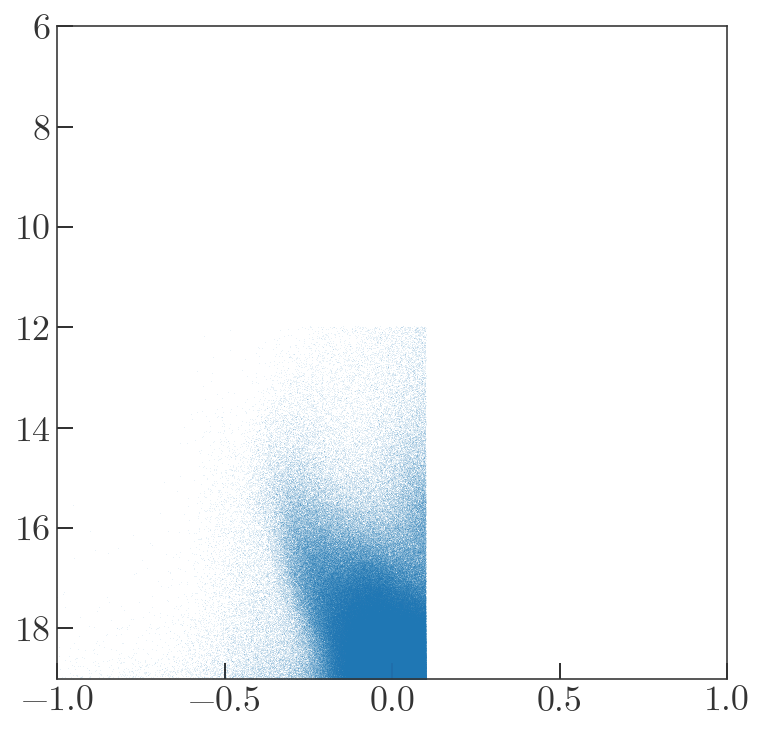

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(bprp, G, marker=',', linestyle='none', alpha=0.1)
ax.set_xlim(-1, 1.)
ax.set_ylim(19, 6)

In [11]:
dist = coord.Distance(distmod=G - -1.*u.mag)

In [12]:
all_c = coord.SkyCoord(ra=g.ra, dec=g.dec,
                       distance=dist,
                       pm_ra_cosdec=g.pmra,
                       pm_dec=g.pmdec,
                       radial_velocity=np.zeros(len(g))*u.km/u.s)

In [13]:
len(all_c)

1835449

In [26]:
EBV = sfd(all_c)
G = g.phot_g_mean_mag.value
bp = g.phot_bp_mean_mag.value
rp = g.phot_rp_mean_mag.value
A_G, A_BP, A_RP = get_ext(G, bp, rp, EBV, 3)

2.65821638107
2.57574821472
2.60313017845


/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/lib/polynomial.py:680: RuntimeWarning: overflow encountered in multiply
  y = y * x + p[i]
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: overflow encountered in multiply
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:38: RuntimeWarning: overflow encountered in multiply
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: overflow encountered in multiply


In [27]:
bprp0 = (bp - rp) - (A_BP - A_RP)
G0 = G - A_G

In [56]:
smc_mask = (smc_c.separation(all_c) < 5*u.deg) & (smc_c.separation(all_c) > 2*u.deg)
smc_mask.sum()

51425

(19, 6)

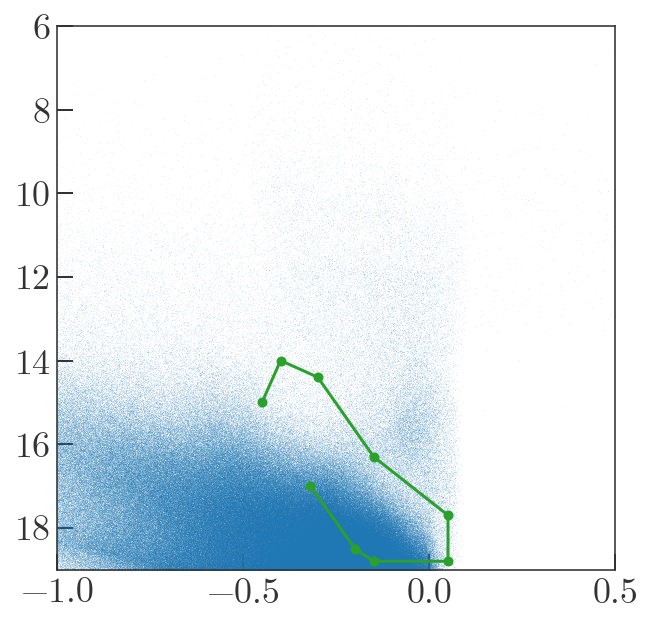

In [108]:
ddm = (coord.Distance(30*u.kpc).distmod - coord.Distance(30*u.kpc).distmod).value
smc_cmd_nodes = np.array([[-0.32, 17],
                          [-0.2, 18.5],
                          [-0.15, 18.8],
                          [0.05, 18.8],
                          [0.05, 17.7],
                          [-0.15, 16.3],
                          [-0.3, 14.4],
                          [-0.4, 14],
                          [-0.45, 15]])
smc_cmd_nodes[:, 1] -= ddm
smc_path = mpl.patches.Path(smc_cmd_nodes)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(bprp0, G0, marker=',', linestyle='none', alpha=0.1)
# ax.plot(bprp0[smc_mask], G0[smc_mask]-1.8, marker=',', linestyle='none', alpha=0.8)
ax.plot(smc_cmd_nodes[:, 0], smc_cmd_nodes[:, 1], color='tab:green', marker='o', zorder=100)
ax.set_xlim(-1, 0.5)
ax.set_ylim(19, 6)

In [109]:
smc_cmd_mask = smc_path.contains_points(np.vstack((bprp0, G0)).T)

In [110]:
mag_c = all_c.transform_to(gc.MagellanicStream)
mag_mask = np.logical_not((mag_c.L.wrap_at(180*u.deg) < 10*u.deg) & 
                          (mag_c.L.wrap_at(180*u.deg) > -20*u.deg) & 
                          (mag_c.B < 15*u.deg) & (mag_c.B > -20*u.deg))

# more_mask = np.ones(len(mag_mask)).astype(bool)
# more_mask = (bprp0 < 0.1) & (bprp0 > -0.15) & (G0 < 16.4) & (G0 > 14)
more_mask = smc_cmd_mask

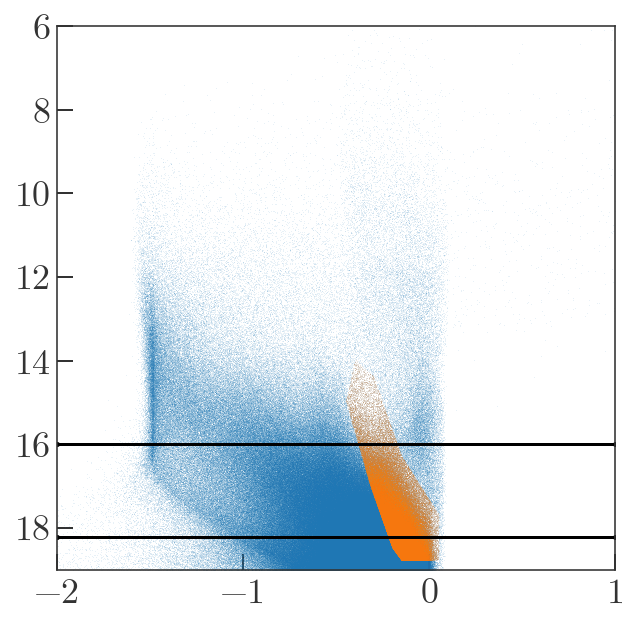

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(bprp0, G0, marker=',', linestyle='none', alpha=0.1)
ax.plot(bprp0[more_mask], G0[more_mask], marker=',', linestyle='none', alpha=0.1)
ax.set_xlim(-2, 1.)
ax.set_ylim(19, 6)

ax.axhline((coord.Distance(70*u.kpc).distmod - 1*u.mag).value)
ax.axhline((coord.Distance(25*u.kpc).distmod - 1*u.mag).value)

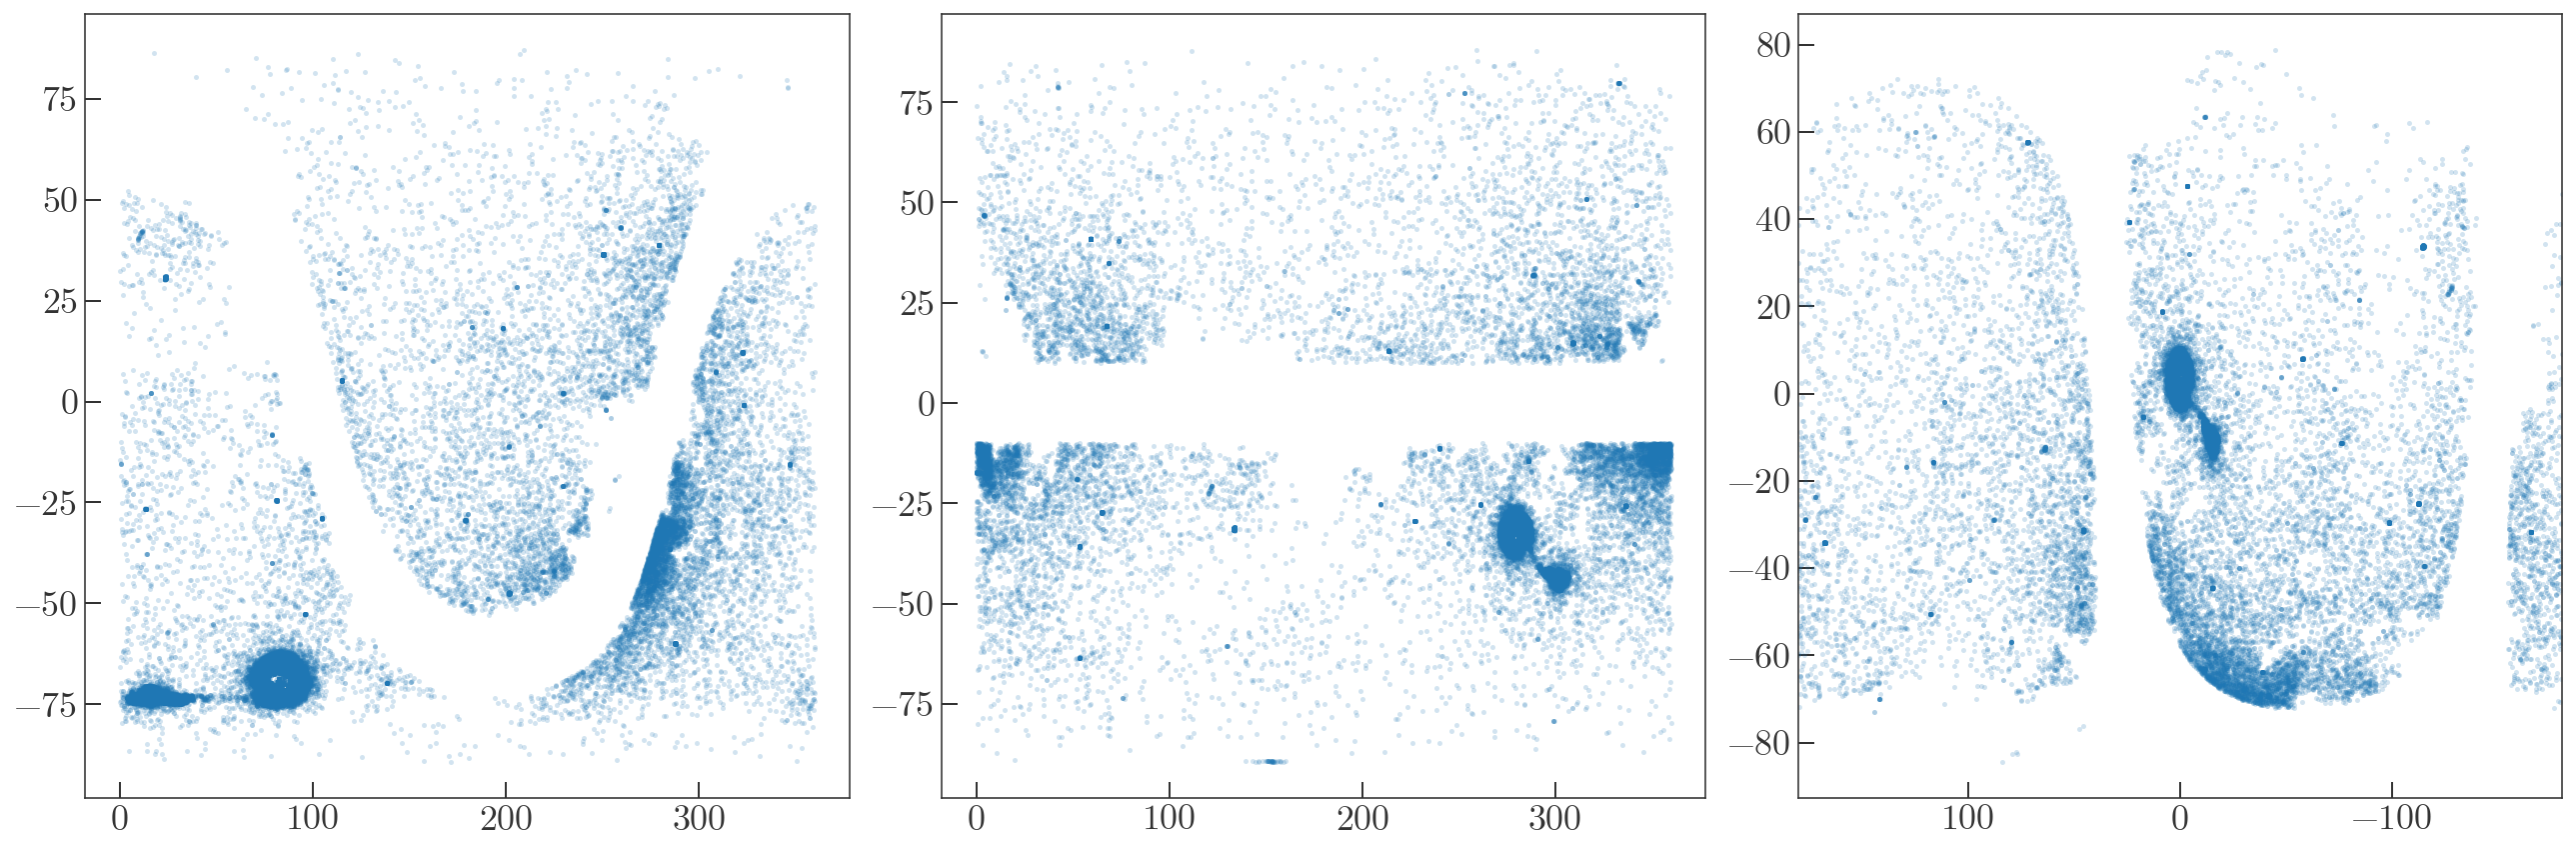

In [112]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].plot(all_c.ra.degree[more_mask], all_c.dec.degree[more_mask], 
             marker='.', linestyle='none', alpha=0.2)

axes[1].plot(all_c.galactic.l.degree[more_mask], all_c.galactic.b.degree[more_mask], 
             marker='.', linestyle='none', alpha=0.2)

axes[2].plot(mag_c.L.wrap_at(180*u.deg).degree[more_mask], 
             mag_c.B.degree[more_mask], 
             marker='.', linestyle='none', alpha=0.2)
axes[2].set_xlim(180, -180)

fig.tight_layout()

In [113]:
mag_mask.sum()

225500

In [114]:
c = all_c[mag_mask & more_mask]

---

In [115]:
from matplotlib.gridspec import GridSpec

In [116]:
mag_c = gc.reflex_correct(c.transform_to(gc.MagellanicStream))
gal_c = c.galactic

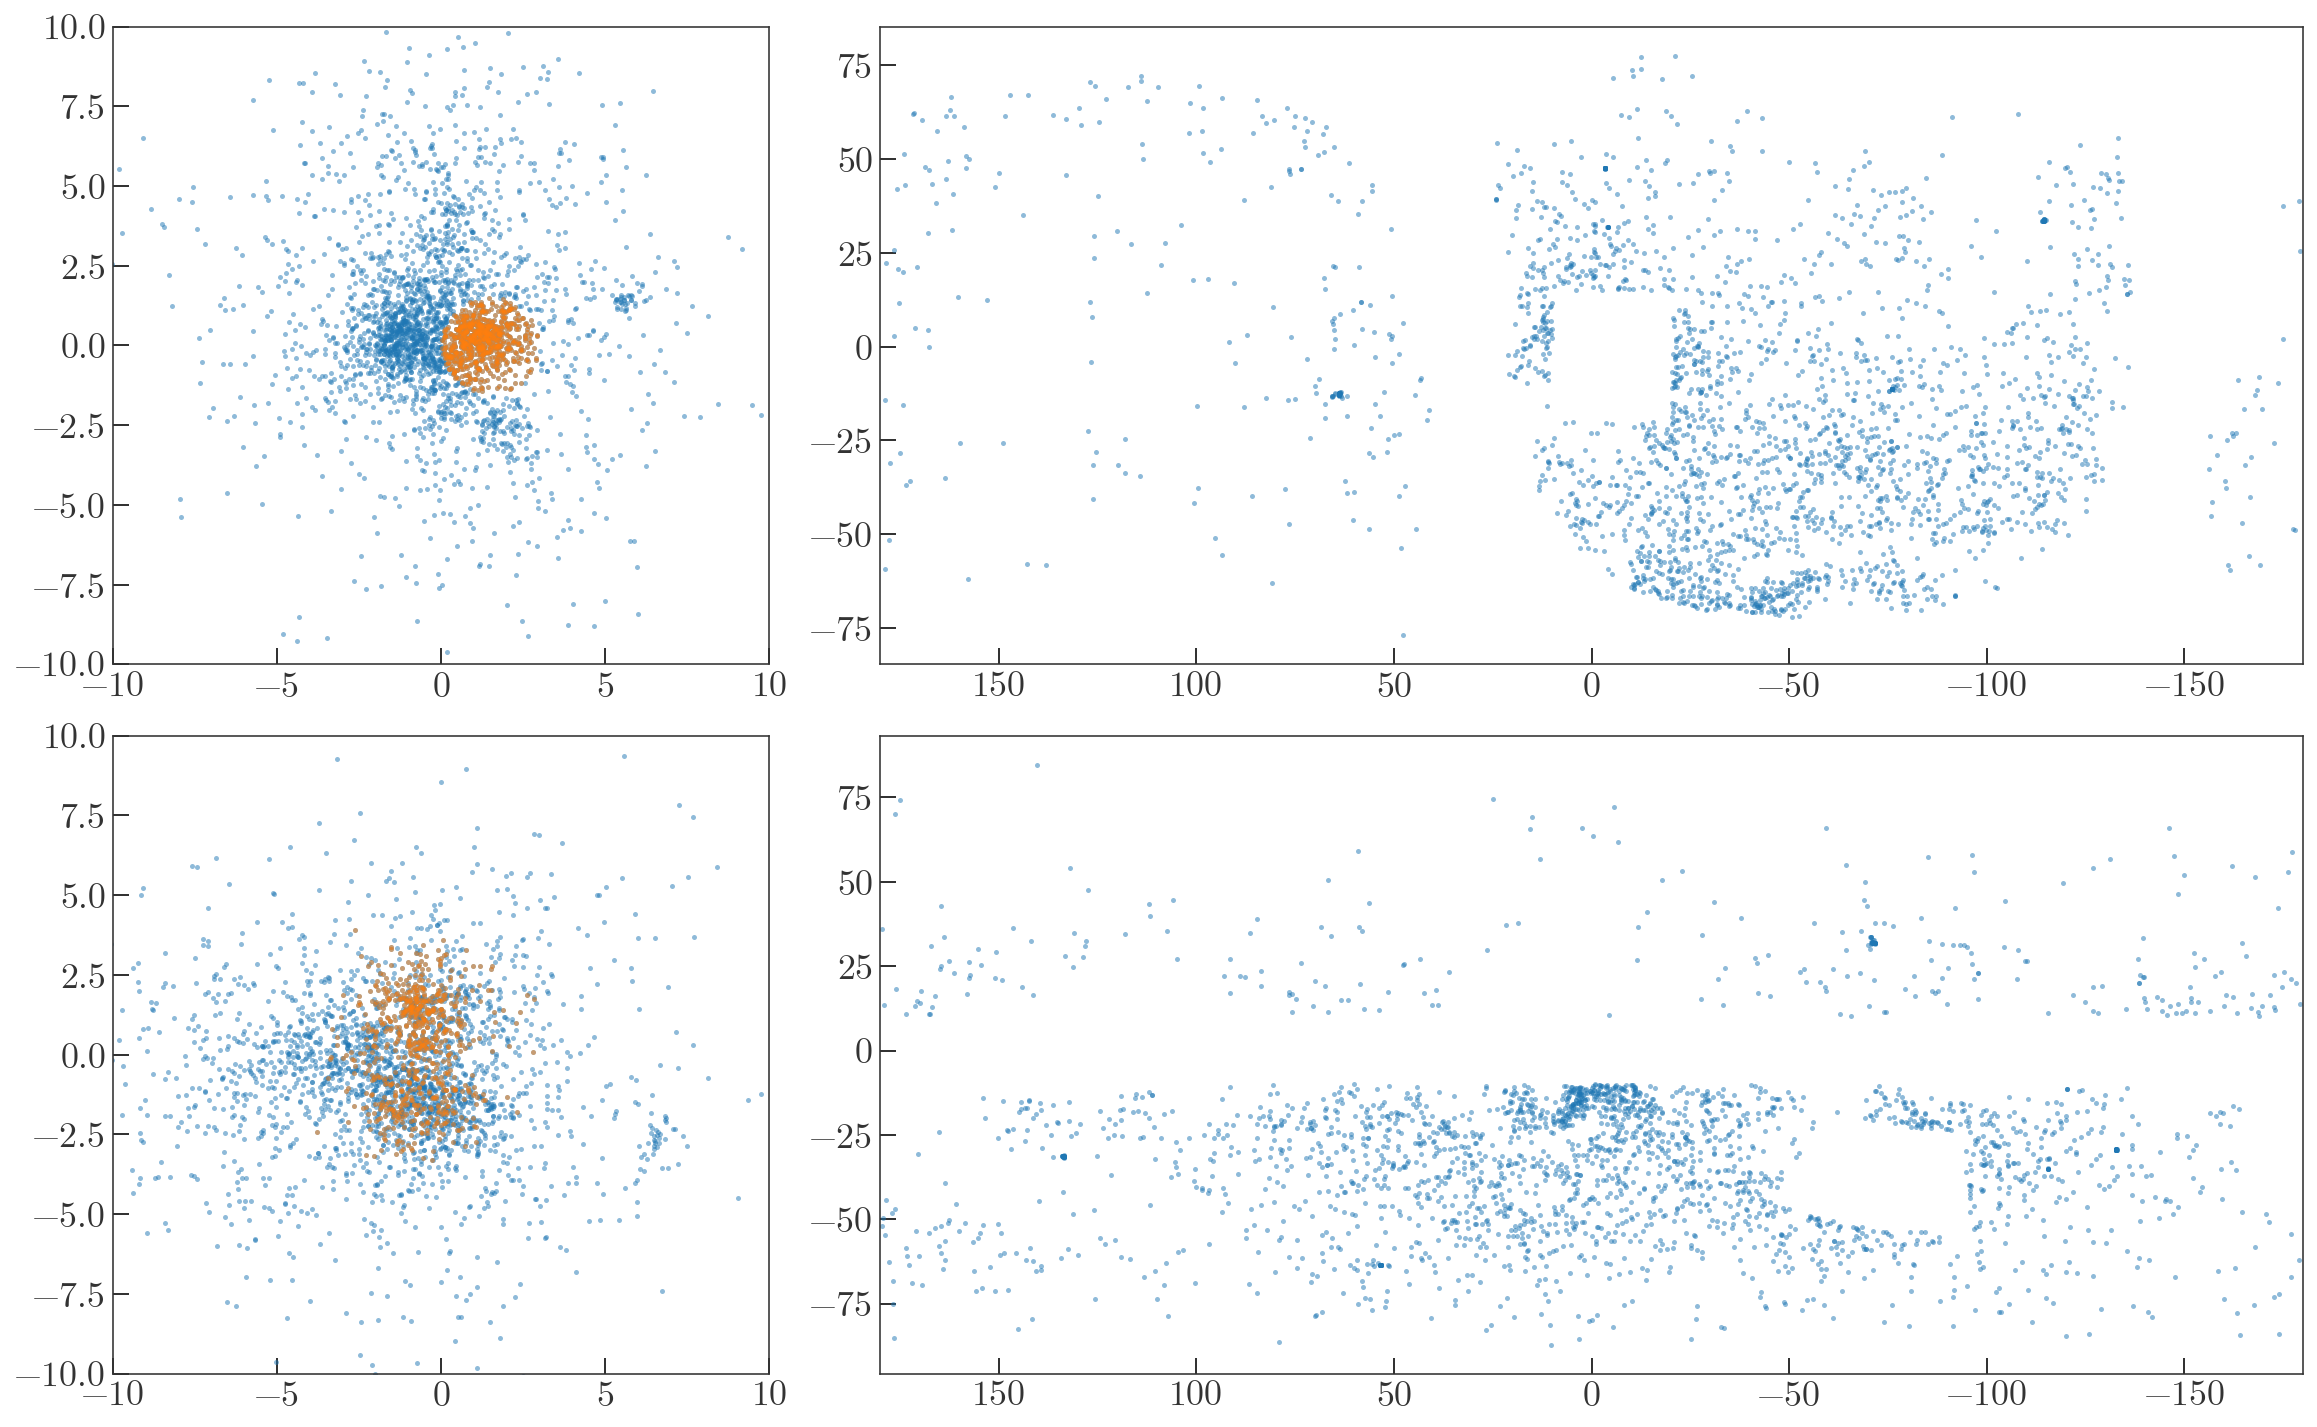

In [126]:
mag_B_mask = np.abs(mag_c.B) < 20*u.deg
# mag_pm_mask = (mag_c.pm_B < 2.1*u.mas/u.yr) & (mag_c.pm_B > .5*u.mas/u.yr) & (mag_c.pm_L_cosB > 0)
# mag_pm_mask = np.sqrt( (mag_c.pm_L_cosB - -1*u.mas/u.yr)**2 + (mag_c.pm_B - -0*u.mas/u.yr)**2 ) < 1*u.mas/u.yr
# mag_pm_mask = np.sqrt( (gal_c.pm_l_cosb - 6.5*u.mas/u.yr)**2 + (gal_c.pm_b - -2.7*u.mas/u.yr)**2 ) < 1*u.mas/u.yr
mag_pm_mask = ((np.sqrt( (mag_c.pm_L_cosB - 1.5*u.mas/u.yr)**2 + (mag_c.pm_B - 0*u.mas/u.yr)**2 ) < 1.5*u.mas/u.yr))
                      
fig = plt.figure(figsize=(16, 10))

gs = GridSpec(2, 3)

ax = fig.add_subplot(gs[0, 0])
ax.plot(mag_c.pm_L_cosB.value[mag_B_mask],
        mag_c.pm_B.value[mag_B_mask],
        marker='.', linestyle='none', alpha=0.5)

ax.plot(mag_c.pm_L_cosB.value[mag_B_mask & mag_pm_mask],
        mag_c.pm_B.value[mag_B_mask & mag_pm_mask],
        marker='.', linestyle='none', alpha=0.5)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

# ---

ax = fig.add_subplot(gs[0, 1:])
ax.plot(mag_c.L.wrap_at(180*u.deg).degree[mag_pm_mask], 
        mag_c.B.degree[mag_pm_mask], 
        marker='.', linestyle='none', alpha=0.5)
ax.set_xlim(180, -180)

# ---

ax = fig.add_subplot(gs[1, 0])
ax.plot(gal_c.pm_l_cosb.value[mag_B_mask],
        gal_c.pm_b.value[mag_B_mask],
        marker='.', linestyle='none', alpha=0.5)

ax.plot(gal_c.pm_l_cosb.value[mag_B_mask & mag_pm_mask],
        gal_c.pm_b.value[mag_B_mask & mag_pm_mask],
        marker='.', linestyle='none', alpha=0.5)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

# ---

ax = fig.add_subplot(gs[1, 1:])
ax.plot(gal_c.l.wrap_at(180*u.deg).degree[mag_pm_mask], 
        gal_c.b.degree[mag_pm_mask], 
        marker='.', linestyle='none', alpha=0.5)
ax.set_xlim(180, -180)

fig.tight_layout()

---

In [128]:
idx1, idx2, sep, _ = coord.search_around_sky(c, c, seplimit=2*u.deg)

In [129]:
dpm = np.sqrt((c[idx1].pm_ra_cosdec - c[idx2].pm_ra_cosdec)**2 + (c[idx1].pm_dec - c[idx2].pm_dec)**2)

In [130]:
# pm_h = (20*u.km/u.s / (c[idx1].distance)).to(u.mas/u.yr, u.dimensionless_angles())
# pm_h = (10*u.km/u.s / (25*u.kpc)).to(u.mas/u.yr, u.dimensionless_angles())
pm_h = 0.4*u.mas/u.yr

In [131]:
pm_mask = (dpm < pm_h) & (dpm > 0*u.mas/u.yr)
pm_mask.sum()

14492

In [132]:
pm_idx1 = idx1[pm_mask]
pm_idx2 = idx2[pm_mask]

In [133]:
N_gtr_3 = 0
mean_c = []
all_idx = []
for i1 in np.unique(pm_idx1):
    i2s = pm_idx2[pm_idx1 == i1]
    
    if len(i2s) < 5:
        continue
        
    N_gtr_3 += 1
    
    mean_c.append([np.mean(c[i2s].ra.degree),
                   np.mean(c[i2s].dec.degree),
                   np.mean(c[i2s].pm_ra_cosdec.value),
                   np.mean(c[i2s].pm_dec.value)])
    all_idx.append(i2s)

mean_c = np.array(mean_c)
mean_c = coord.SkyCoord(ra=mean_c[:,0]*u.deg, dec=mean_c[:,1]*u.deg,
                        pm_ra_cosdec=mean_c[:,2]*u.mas/u.yr, 
                        pm_dec=mean_c[:,3]*u.mas/u.yr)
all_idx = np.array(all_idx)

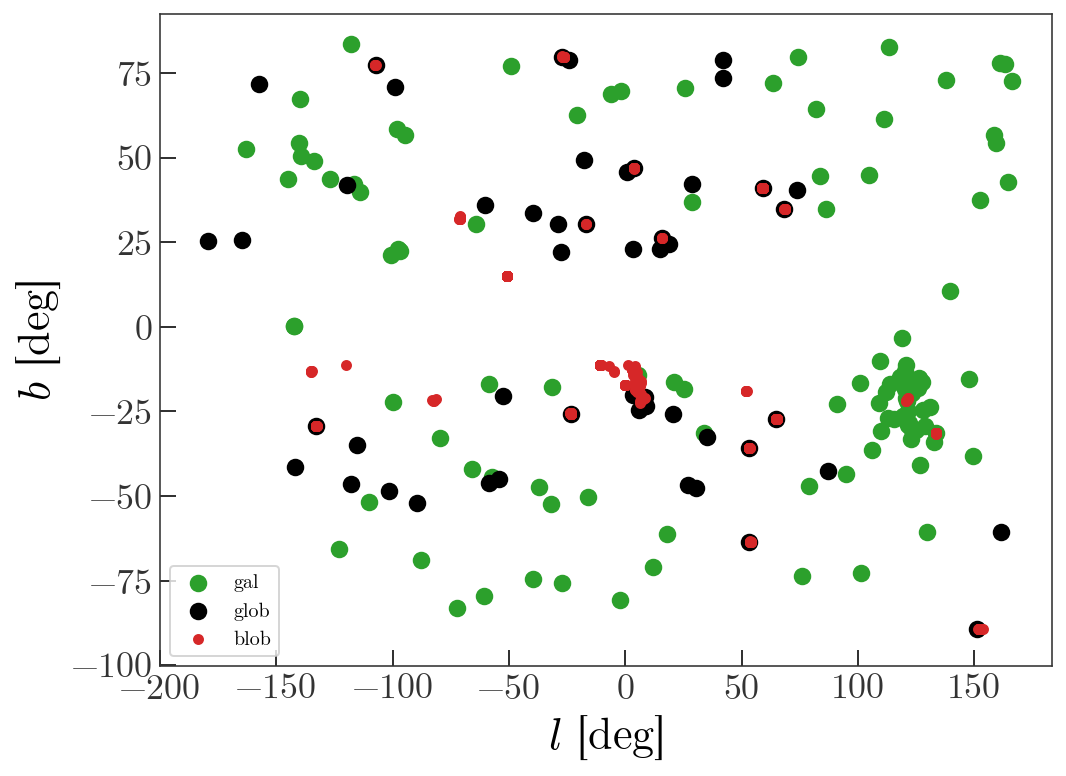

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(gals_c.galactic.l.wrap_at(180*u.deg),
           gals_c.galactic.b, marker='o', s=60, 
           color='tab:green', zorder=-10, label='gal')

ax.scatter(glob_c.galactic.l.wrap_at(180*u.deg),
           glob_c.galactic.b, marker='o', s=60, 
           color='k', zorder=-10, label='glob')

ax.scatter(mean_c.galactic.l.wrap_at(180*u.deg), 
           mean_c.galactic.b, 
           s=20, color='tab:red', label='blob')

ax.legend(loc='lower left')

ax.set_xlabel('$l$ [deg]')
ax.set_ylabel('$b$ [deg]')

In [135]:
idx, sep, _ = mean_c.match_to_catalog_sky(glob_c)
unknown_mask = sep > 0.5*u.deg

idx, sep, _ = mean_c.match_to_catalog_sky(gals_c)
unknown_mask &= sep > 0.5*u.deg

unknown_mask.sum()

236

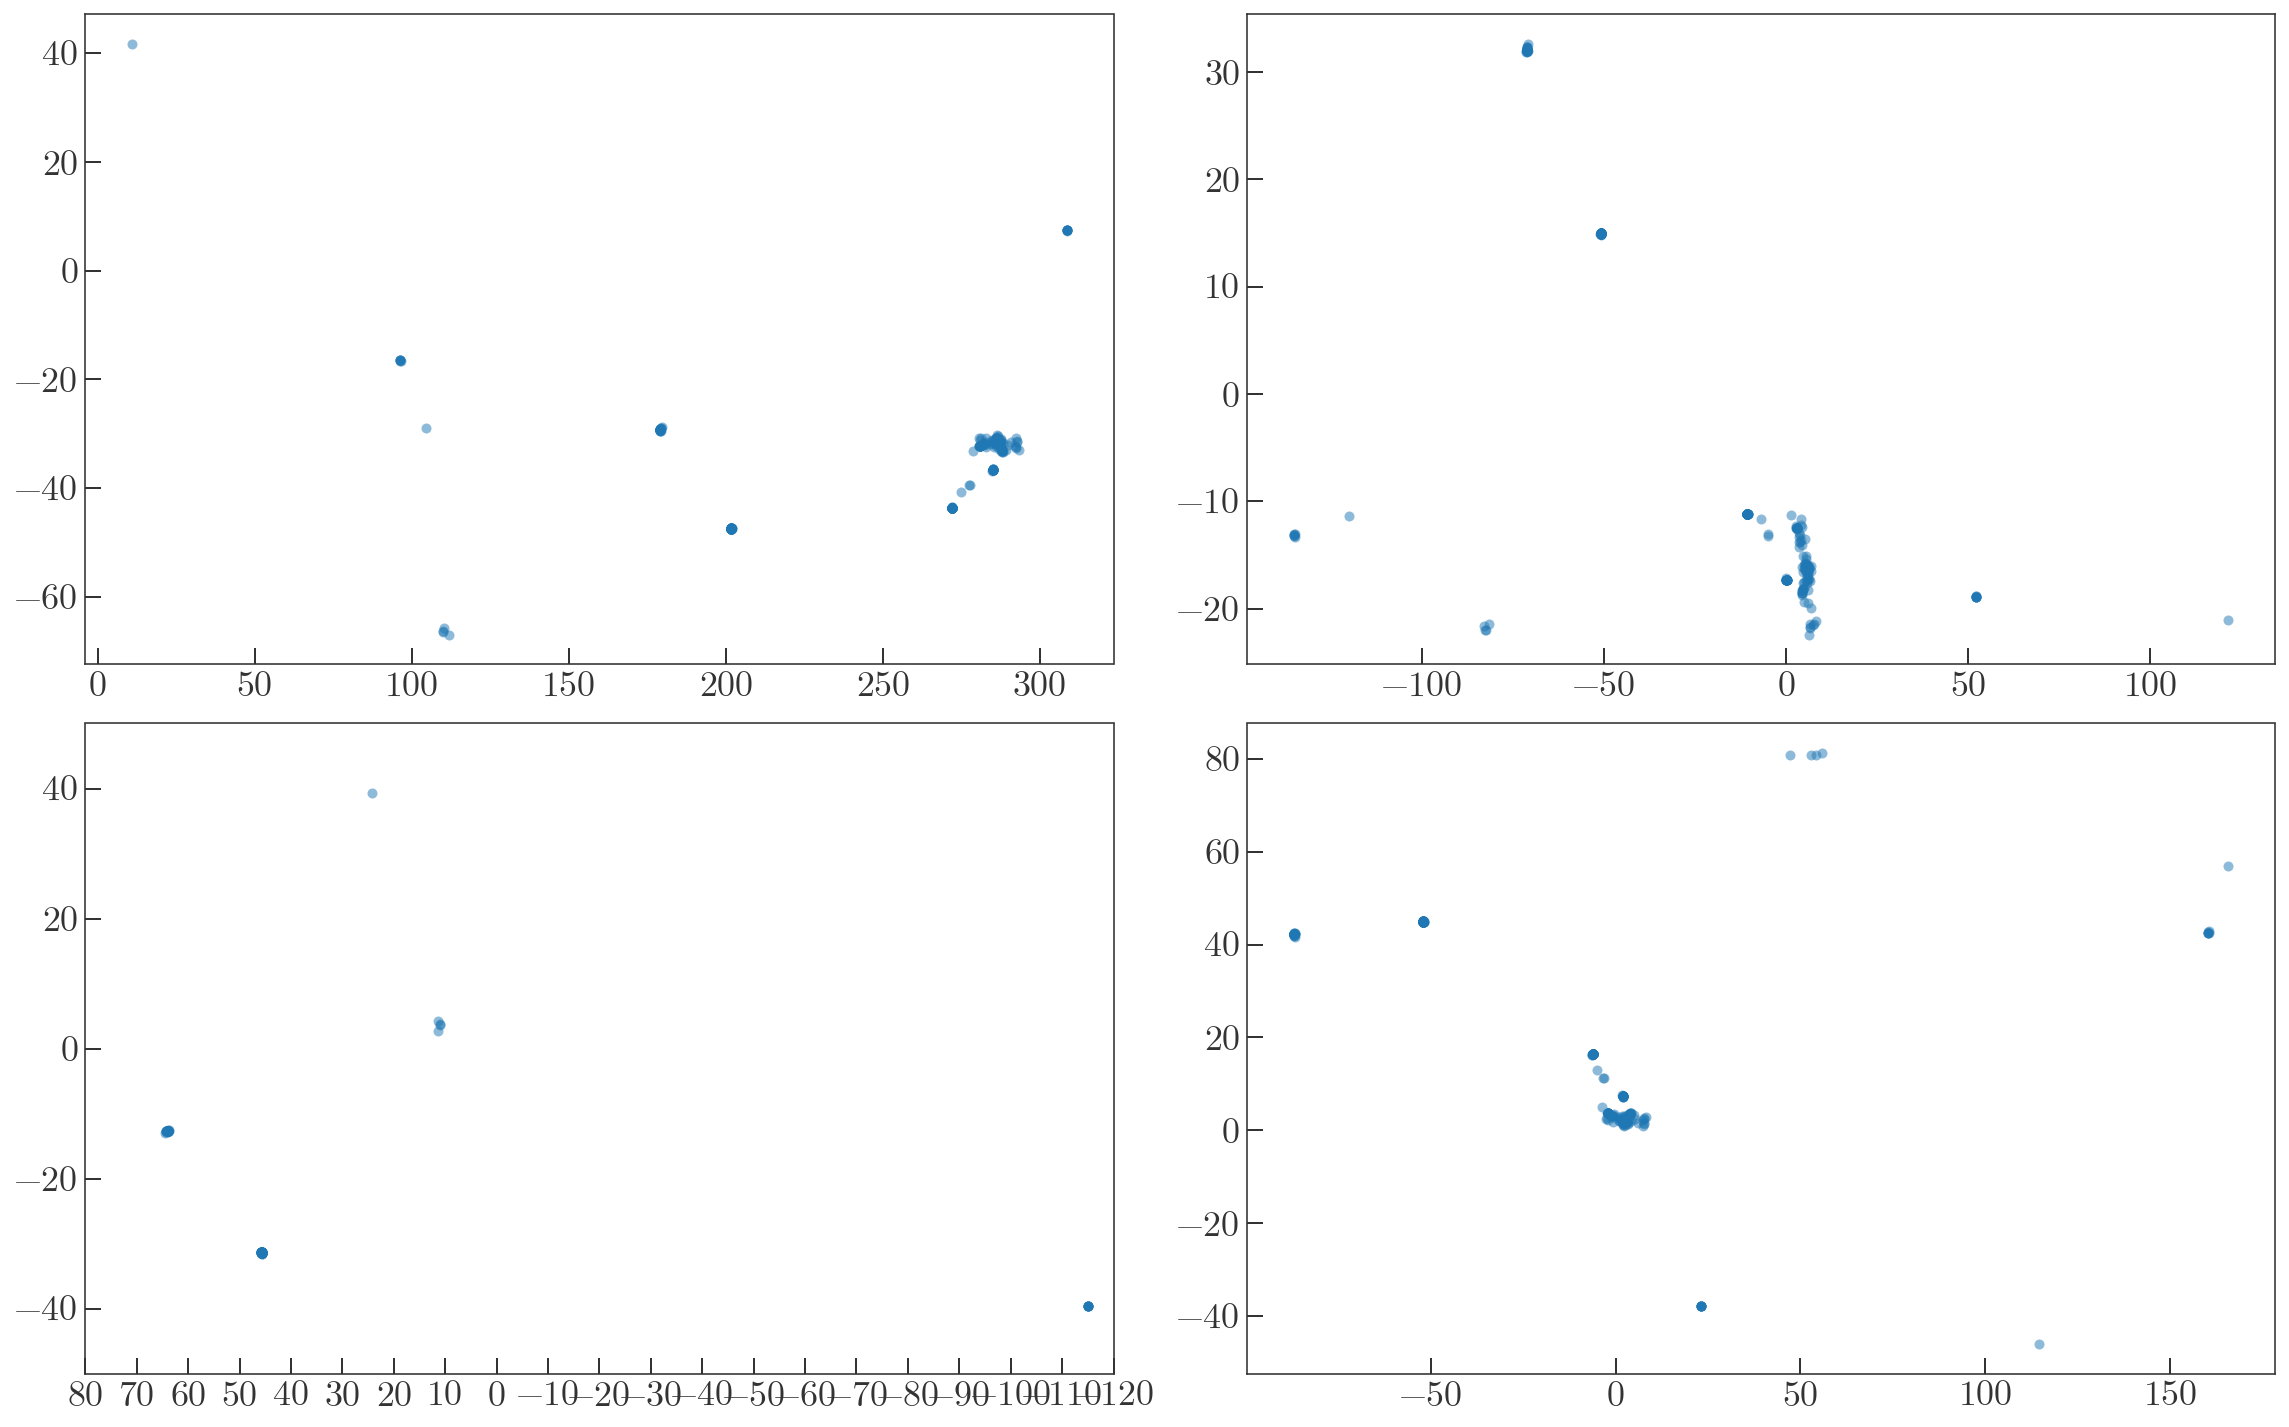

In [141]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
style = dict(marker='o', linestyle='none', 
             alpha=0.5, color='tab:blue')

axes[0,0].plot(mean_c.ra[unknown_mask], 
               mean_c.dec[unknown_mask], **style)

axes[0,1].plot(mean_c.galactic.l.wrap_at(180*u.deg)[unknown_mask], 
               mean_c.galactic.b[unknown_mask], **style)

_mag = mean_c.transform_to(gc.MagellanicStream)
axes[1,0].plot(_mag.L.wrap_at(180*u.deg).degree[unknown_mask], 
               _mag.B.degree[unknown_mask], **style)
axes[1,0].set_xlim(80, -120)
axes[1,0].set_xticks(np.arange(-120, 80+1, 10))
axes[1,0].set_ylim(-50, 50)

_sag = mean_c.transform_to(gc.Sagittarius)
axes[1,1].plot(_sag.Lambda.wrap_at(180*u.deg).degree[unknown_mask], 
               _sag.Beta.degree[unknown_mask], **style)

fig.tight_layout()

### Focus on the two that might be LMC gas??

In [247]:
group_mag = _mag[_mag.separation(coord.SkyCoord(L=65*u.deg, B=-15*u.deg, frame=gc.MagellanicStream)) < 5*u.deg]
group_c = group_mag.transform_to(coord.ICRS)

In [146]:
q_fmt ='''SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec, gaia.radial_velocity, 
gaia.phot_g_mean_mag, gaia.phot_bp_mean_mag, gaia.phot_rp_mean_mag, 
ps1.g_mean_psf_mag, ps1.r_mean_psf_mag, ps1.i_mean_psf_mag, ps1.z_mean_psf_mag, ps1.y_mean_psf_mag
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.panstarrs1_best_neighbour AS xmatch
    ON gaia.source_id = xmatch.source_id
INNER JOIN gaiadr2.panstarrs1_original_valid AS ps1
    ON ps1.obj_id = xmatch.original_ext_source_id
WHERE gaia.parallax < 1 AND 
    (ps1.g_mean_psf_mag - ps1.i_mean_psf_mag) > -1 AND 
    (ps1.g_mean_psf_mag - ps1.i_mean_psf_mag) < 1 AND 
    CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), 
             CIRCLE('ICRS', {0}, {1}, {2})) = 1 AND
    (pmra > -15) AND (pmra < 15) AND 
    (pmdec > -15) AND (pmdec < 15) 
'''

In [148]:
ra = np.median(group_c.ra.degree)
dec = np.median(group_c.dec.degree)
job = Gaia.launch_job_async(q_fmt.format(ra, dec, 3.))

Launched query: 'SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec, gaia.radial_velocity, 
gaia.phot_g_mean_mag, gaia.phot_bp_mean_mag, gaia.phot_rp_mean_mag, 
ps1.g_mean_psf_mag, ps1.r_mean_psf_mag, ps1.i_mean_psf_mag, ps1.z_mean_psf_mag, ps1.y_mean_psf_mag
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.panstarrs1_best_neighbour AS xmatch
    ON gaia.source_id = xmatch.source_id
INNER JOIN gaiadr2.panstarrs1_original_valid AS ps1
    ON ps1.obj_id = xmatch.original_ext_source_id
WHERE gaia.parallax < 1 AND 
    (ps1.g_mean_psf_mag - ps1.i_mean_psf_mag) > -1 AND 
    (ps1.g_mean_psf_mag - ps1.i_mean_psf_mag) < 1 AND 
    CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), 
             CIRCLE('ICRS', 179.11654750689576, -29.299042928561295, 3.0)) = 1 AND
    (pmra > -15) AND (pmra < 15) AND 
    (pmdec > -15) AND (pmdec < 15) 
'
Retrieving async. results...


Query finished.


In [149]:
tbl = job.get_results()

In [150]:
len(tbl)

64918

In [238]:
# tbl.write(bhb_fn)

In [248]:
group_g = GaiaData(tbl)
all_group_c = coord.SkyCoord(ra=group_g.ra,
                             dec=group_g.dec,
                             pm_ra_cosdec=group_g.pmra,
                             pm_dec=group_g.pmdec)

493

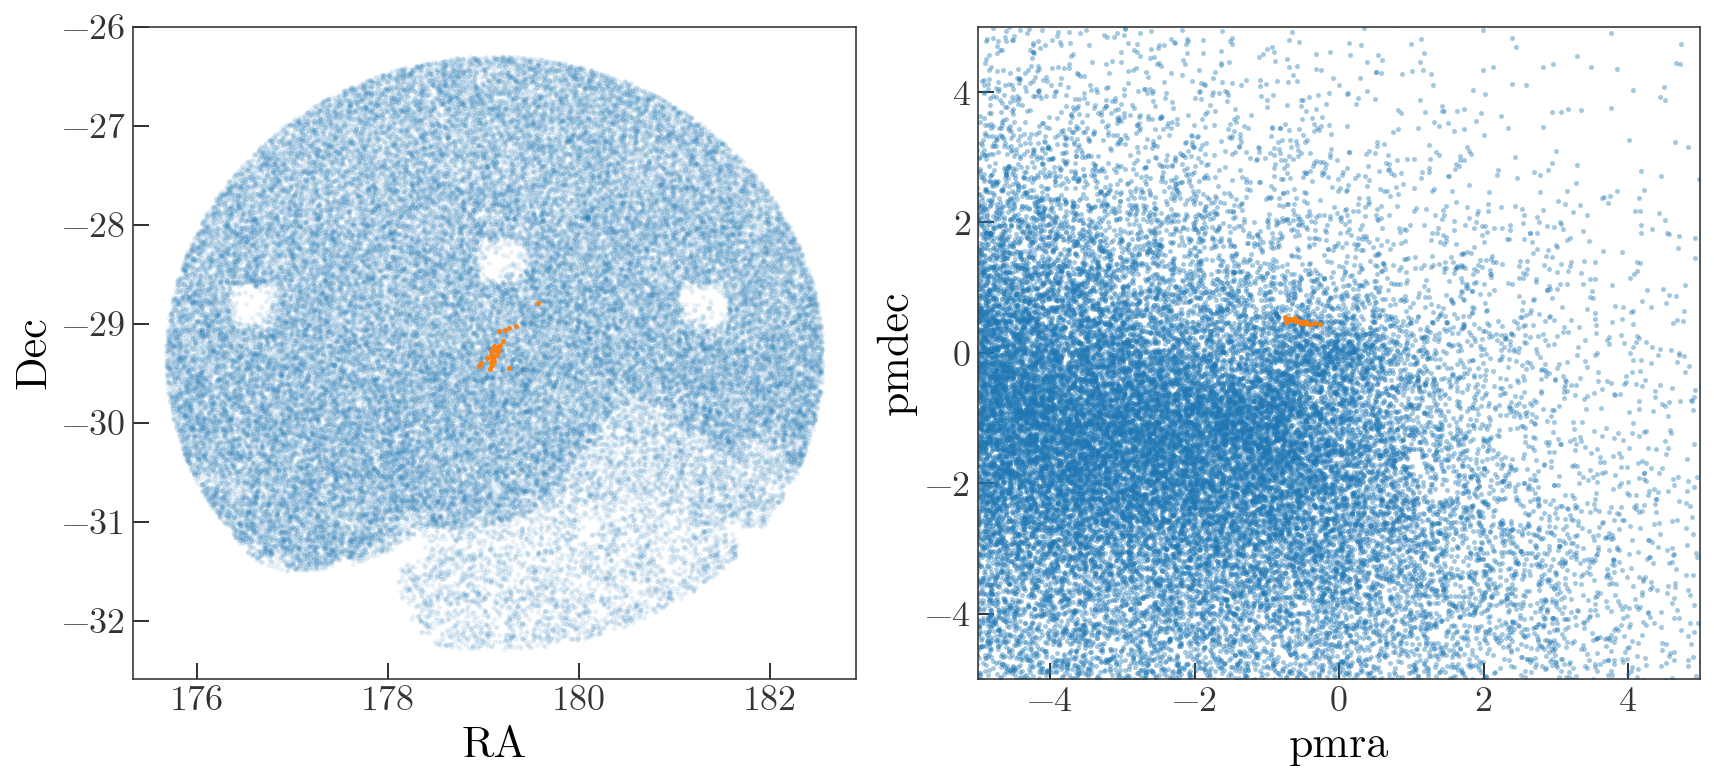

In [263]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))

axes[0].plot(group_g.ra, group_g.dec,
             marker='.', linestyle='none', alpha=0.1)
axes[0].plot(group_c.ra, group_c.dec,
             marker='.', linestyle='none', alpha=1.)
axes[0].set_xlabel('RA')
axes[0].set_ylabel('Dec')

axes[1].plot(group_g.pmra, group_g.pmdec,
             marker='.', linestyle='none', alpha=0.4)
axes[1].plot(group_c.pm_ra_cosdec, group_c.pm_dec,
             marker='.', linestyle='none', alpha=1.)
# axes[1].set_xlim(-2, 1)
# axes[1].set_ylim(-1, 2)
axes[1].set_xlim(-5, 5)
axes[1].set_ylim(-5, 5)
axes[1].set_xlabel('pmra')
axes[1].set_ylabel('pmdec')

fig.tight_layout()

pmra = np.mean(group_c.pm_ra_cosdec)
pmdec = np.mean(group_c.pm_dec)
group_pm_mask = np.sqrt((group_g.pmra - pmra)**2 + (group_g.pmdec - pmdec)**2) < 0.6*u.mas/u.yr
# group_pm_mask = np.sqrt((group_g.pmra)**2 + (group_g.pmdec)**2) < 0.75*u.mas/u.yr
group_pm_mask.sum()

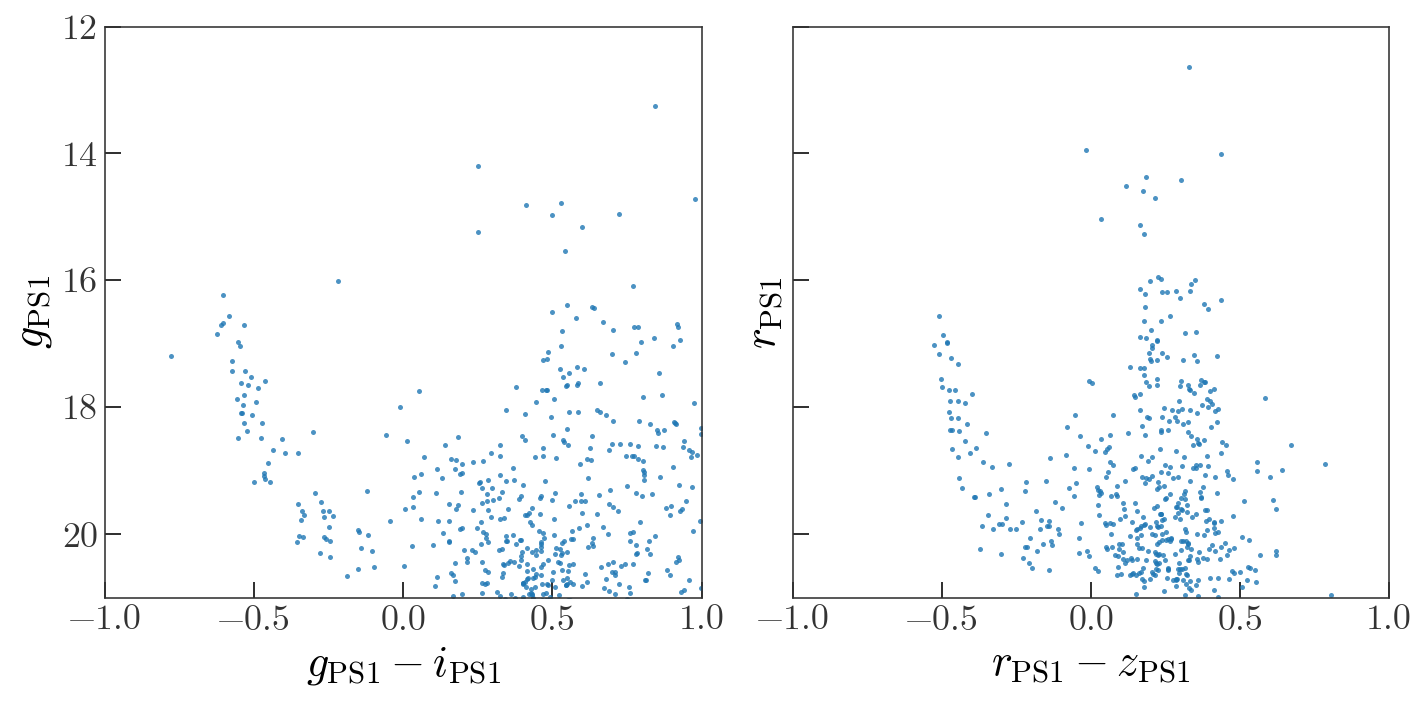

In [275]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

axes[0].plot((group_g.g_mean_psf_mag - group_g.i_mean_psf_mag)[group_pm_mask], 
             group_g.g_mean_psf_mag[group_pm_mask],
             marker='.', linestyle='none', alpha=0.8)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_xlim(-1, 1)
axes[0].set_ylim(21, 12)

gi_nodes = np.array([[-0.55, 16],
                     [-0.4, 18.7],
                     [0, 20],
                     [0, 21],
                     [-0.5, 20],
                     [-0.6, 19],
                     [-0.65, 17.],
                     [-0.65, 16]])
gi_path = mpl.patches.Path(gi_nodes)
# axes[0].plot(gi_nodes[:,0], gi_nodes[:,1])

axes[1].plot((group_g.r_mean_psf_mag - group_g.z_mean_psf_mag)[group_pm_mask], 
             group_g.r_mean_psf_mag[group_pm_mask],
             marker='.', linestyle='none', alpha=0.8)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xlim(-1, 1)
axes[1].set_ylim(21, 12)

X = np.vstack(((group_g.g_mean_psf_mag - group_g.i_mean_psf_mag),
                group_g.g_mean_psf_mag)).T
gi_mask = gi_path.contains_points(X)


axes[0].set_xlabel(r'$g_{\rm PS1} - i_{\rm PS1}$')
axes[0].set_ylabel(r'$g_{\rm PS1}$')

axes[1].set_xlabel(r'$r_{\rm PS1} - z_{\rm PS1}$')
axes[1].set_ylabel(r'$r_{\rm PS1}$')

fig.tight_layout()
fig.savefig('/Users/adrian/Downloads/cmd.png', dpi=250)

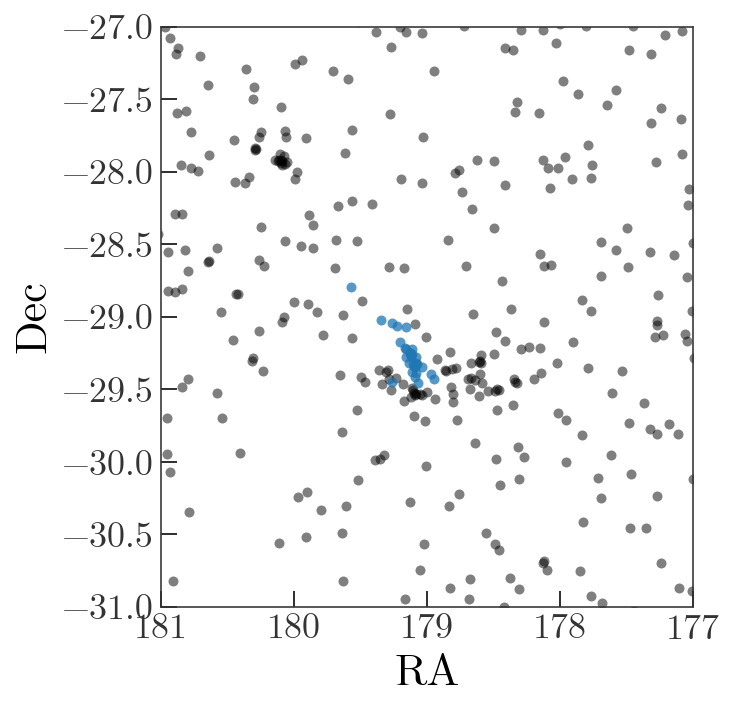

In [274]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(group_g.ra[group_pm_mask], group_g.dec[group_pm_mask],
        marker='o', linestyle='none', alpha=0.5, 
        color='k', linewidth=0)
ax.plot(group_c.ra, group_c.dec,
        marker='o', linestyle='none', alpha=0.75, 
        color='tab:blue', linewidth=0)
ax.set_xlim(181, 177)
ax.set_ylim(-31, -27)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
fig.tight_layout()
fig.savefig('/Users/adrian/Downloads/sky.png', dpi=250)

In [169]:
from astropy.io import fits
from astropy.wcs import WCS
import reproject

In [171]:
hdu = fits.open('/Users/adrian/Downloads/allms_coldens_log.fits.gz')[0]

In [179]:
wcs = WCS(hdu.header)

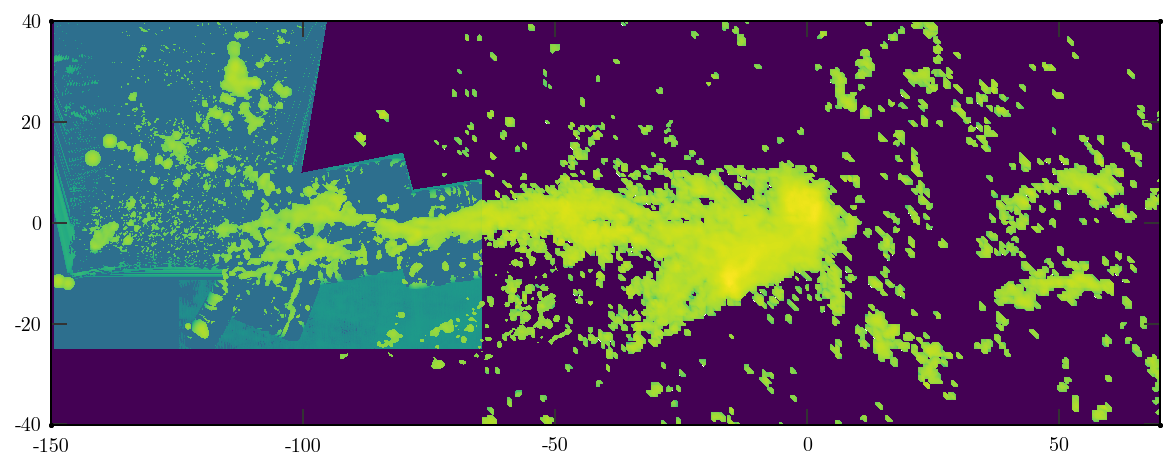

In [188]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw=dict(projection=wcs))
ax.imshow(hdu.data, origin='lower', )
# ax.set_ylim(65, -50)
fig.tight_layout()

In [228]:
hdr = hdu.header.copy()
hdr['CRVAL1'] = 40
wcs2 = WCS(hdr)

In [212]:
arr, _ = reproject.reproject_interp(hdu, wcs2, shape_out=(1601, 3000))

In [ ]:
group_c = group_g.ra

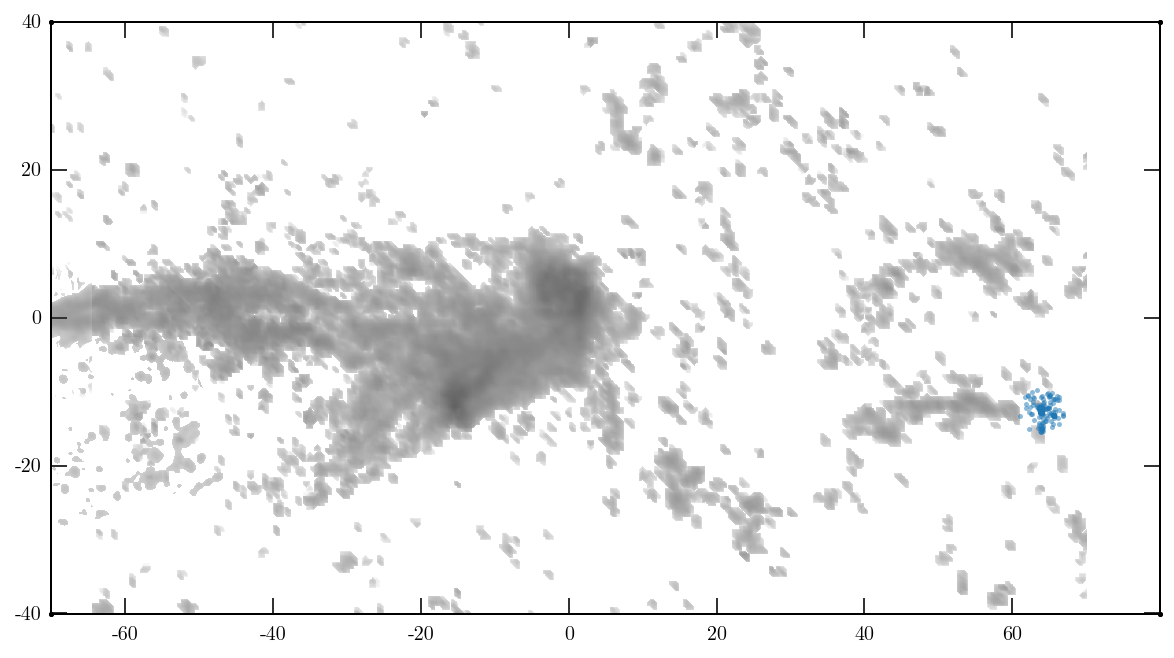

In [251]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw=dict(projection=wcs2))

# ax = fig.add_subplot(gs[0, :], projection=wcs2)
ax.imshow(arr, origin='lower', cmap='Greys', vmin=15, vmax=25)
# ax.scatter(60, -20, transform=ax.get_transform('world'))

# ---
# ax = fig.add_subplot(gs[1, 0], projection=wcs2)

derp = all_group_c.transform_to(gc.MagellanicStream)
ax.plot(derp.L.degree[gi_mask], derp.B.degree[gi_mask],
        marker='.', linestyle='none', alpha=0.5,
        transform=ax.get_transform('world'))
# ax.set_xlabel('RA')
# ax.set_ylabel('Dec')

fig.tight_layout()

fig.savefig('/Users/adrian/Downloads/LMC-coords.png', dpi=250)

(19.5, 10)

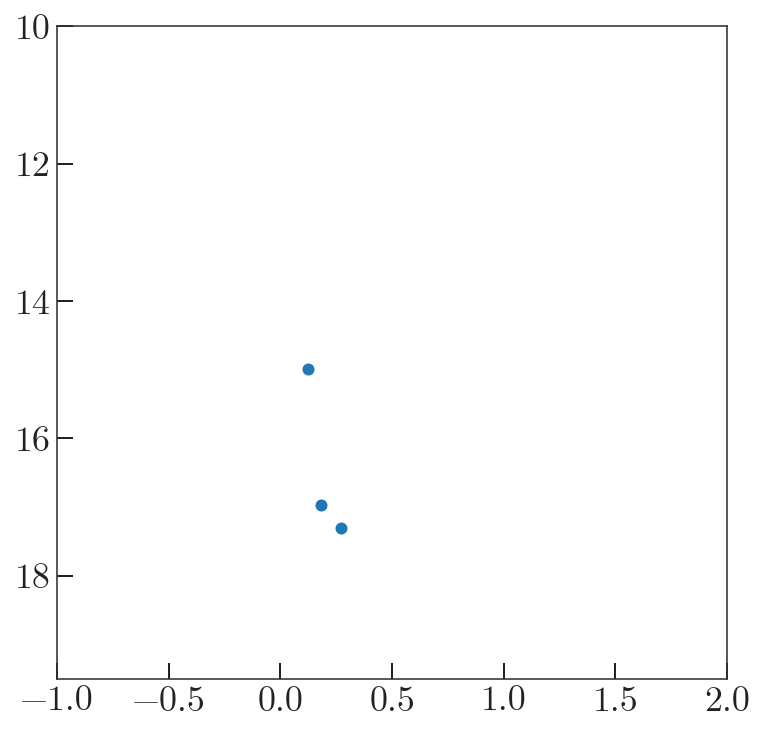

In [179]:
plt.figure(figsize=(6, 6))
plt.scatter(g[mag_mask][cls_to_idx2[group_i]].bp_rp, 
            g[mag_mask][cls_to_idx2[group_i]].phot_g_mean_mag)
plt.xlim(-1, 2)
plt.ylim(19.5, 10)

In [189]:
pmra = np.mean(c[cls_to_idx2[group_i]].pm_ra_cosdec)
pmdec = np.mean(c[cls_to_idx2[group_i]].pm_dec)
group_pm_mask = np.sqrt((group.pmra - pmra)**2 + (group.pmdec - pmdec)**2) < 0.65*u.mas/u.yr

Text(0,0.5,'pmdec')

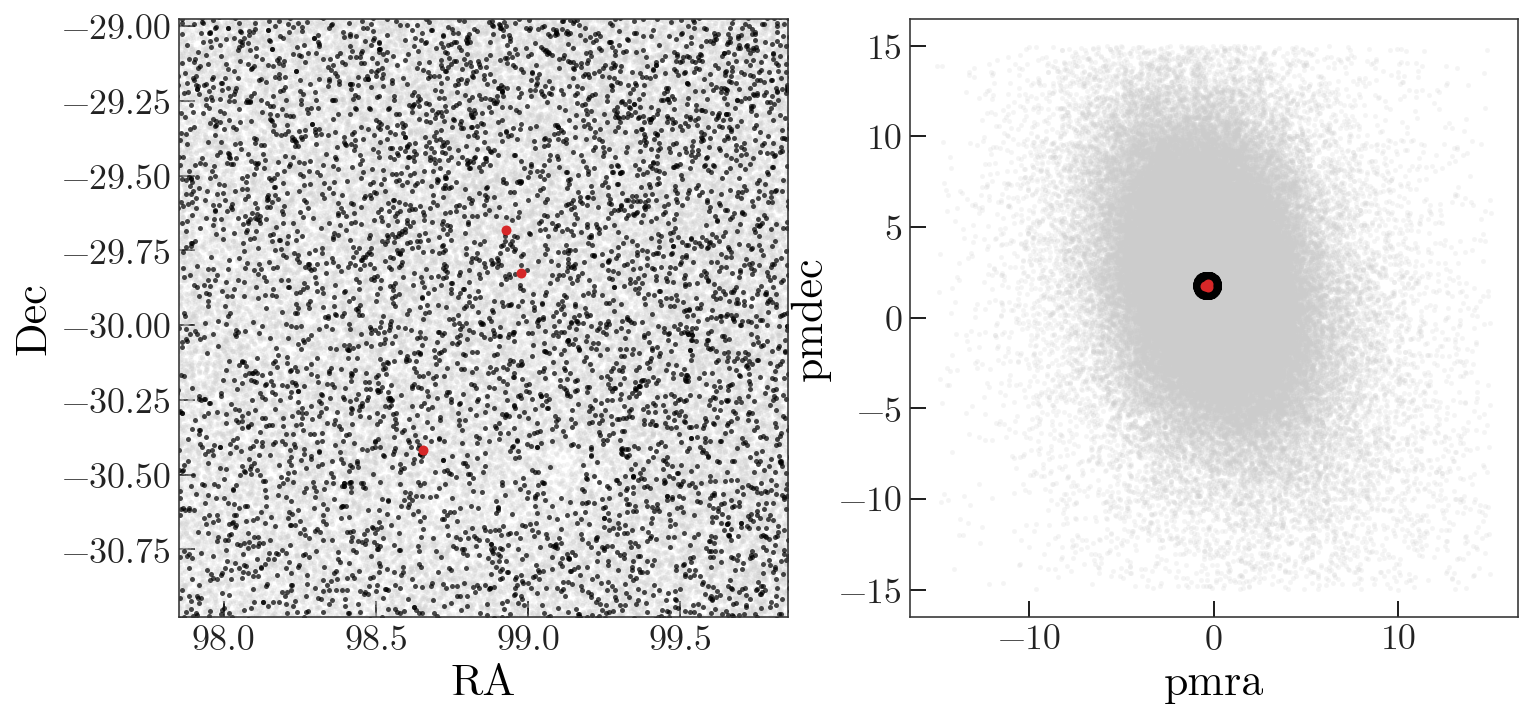

In [190]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))

axes[0].plot(group.ra, group.dec, marker='.', alpha=0.2, color='#cccccc', linestyle='none')
axes[0].plot(group.ra[group_pm_mask], group.dec[group_pm_mask], marker='.', alpha=0.7, color='k', linestyle='none')
axes[0].plot(c[cls_to_idx2[group_i]].ra, c[cls_to_idx2[group_i]].dec, marker='o', color='tab:red', linestyle='none')
axes[0].set_xlabel('RA')
axes[0].set_ylabel('Dec')
axes[0].set_xlim(_x - 1, _x + 1)
axes[0].set_ylim(_y - 1, _y + 1)
axes[0].scatter(gals_c.ra.degree, gals_c.dec.degree)

axes[1].plot(group.pmra, group.pmdec, marker='.', alpha=0.2, color='#cccccc', linestyle='none')
axes[1].plot(group.pmra[group_pm_mask], group.pmdec[group_pm_mask], marker='.', alpha=0.2, color='k', linestyle='none')
axes[1].plot(c[cls_to_idx2[group_i]].pm_ra_cosdec, c[cls_to_idx2[group_i]].pm_dec, marker='o', color='tab:red', linestyle='none')
axes[1].set_xlabel('pmra')
axes[1].set_ylabel('pmdec')

In [191]:
c[cls_to_idx2[group_i]].transform_to(coord.Galactic)

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
    [(238.59469745, -16.20454543, 18.21264839),
     (239.05563443, -16.68724117, 15.62522221),
     (238.43969885, -16.1892233 ,  6.30418921)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-1.81211532, 0.20936663, 9.68388220e-14),
     (-1.70772807, 0.36407368, 9.15758425e-14),
     (-1.84931472, 0.42259686, 2.36834076e-14)]>

Text(0,0.5,'$G$')

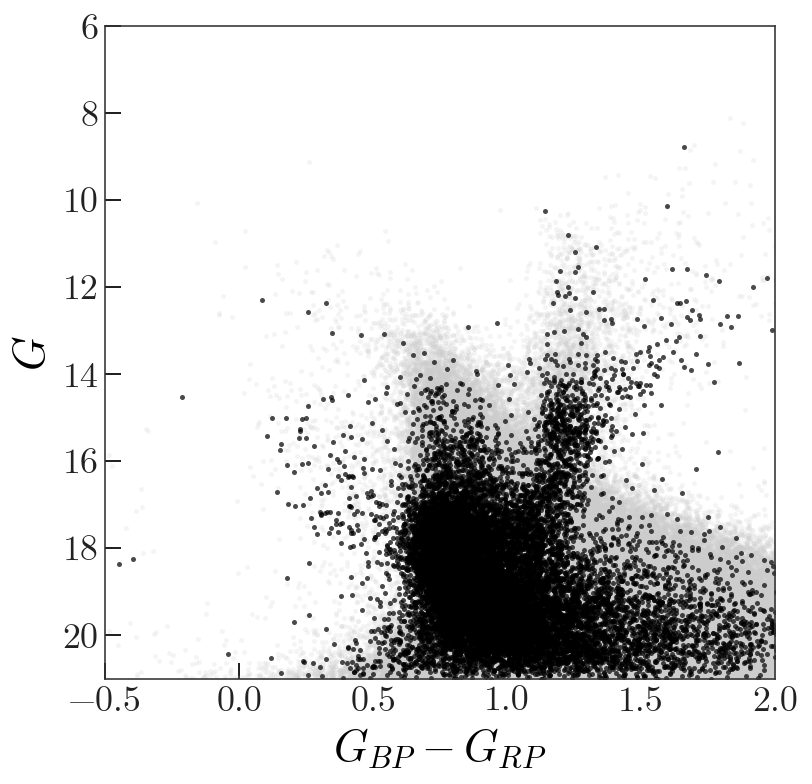

In [192]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(group.bp_rp, group.phot_g_mean_mag, marker='.', alpha=0.2, color='#cccccc', linestyle='none')
ax.plot(group.bp_rp[group_pm_mask], group.phot_g_mean_mag[group_pm_mask],
        marker='.', alpha=0.7, color='k', linestyle='none')

ax.set_xlim(-0.5, 2.)
ax.set_ylim(21, 6)
ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$G$')

In [195]:
cmd_mask = (group.phot_g_mean_mag < 18*u.mag) & (group.bp_rp > 1.05*u.mag) & (group.bp_rp < 1.5*u.mag)
# cmd_mask = (group.phot_g_mean_mag < 19*u.mag) & (group.bp_rp < 0.6*u.mag)

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0,0.5,'pmdec')

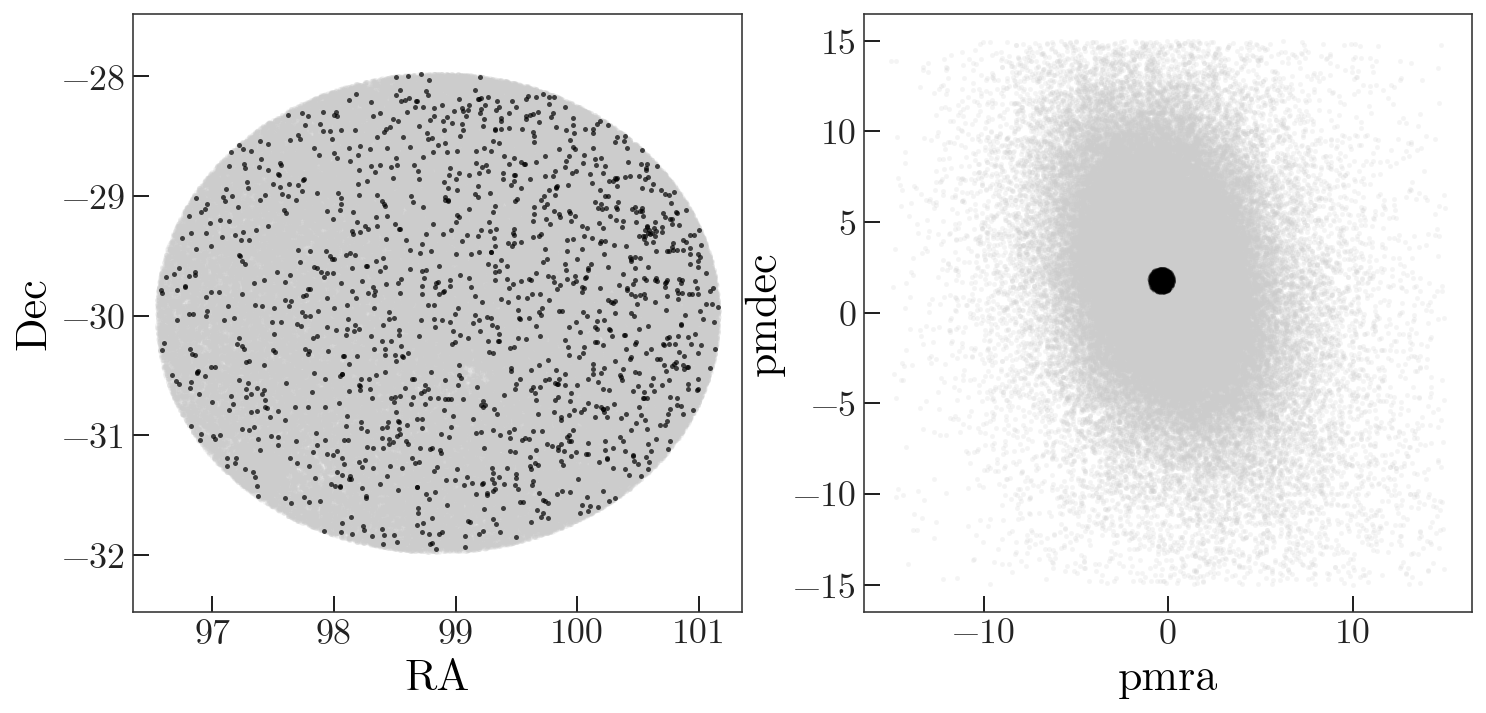

In [200]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))

axes[0].plot(group.ra, group.dec, marker='.', alpha=0.2, color='#cccccc', linestyle='none')
axes[0].plot(group.ra[group_pm_mask&cmd_mask], group.dec[group_pm_mask&cmd_mask], 
             marker='.', alpha=0.7, color='k', linestyle='none')
axes[0].set_xlabel('RA')
axes[0].set_ylabel('Dec')
axes[0].set_xlim(_x - 2.5, _x + 2.5)
axes[0].set_ylim(_y - 2.5, _y + 2.5)
# axes[0].set_xlim(100, _x + 2)
# axes[0].set_ylim(-30, -28.5)
axes[0].scatter(gals_c.ra.degree, gals_c.dec.degree)

axes[1].plot(group.pmra, group.pmdec, marker='.', alpha=0.2, color='#cccccc', linestyle='none')
axes[1].plot(group.pmra[group_pm_mask&cmd_mask], group.pmdec[group_pm_mask&cmd_mask], 
             marker='.', alpha=0.2, color='k', linestyle='none')
axes[1].set_xlabel('pmra')
axes[1].set_ylabel('pmdec')

In [201]:
derp = coord.SkyCoord(ra=100.6*u.deg, dec=-29.3*u.deg)
derp_mask = derp.separation(coord.SkyCoord(ra=group.ra, dec=group.dec)) < 0.12*u.deg

Text(0,0.5,'pmdec')

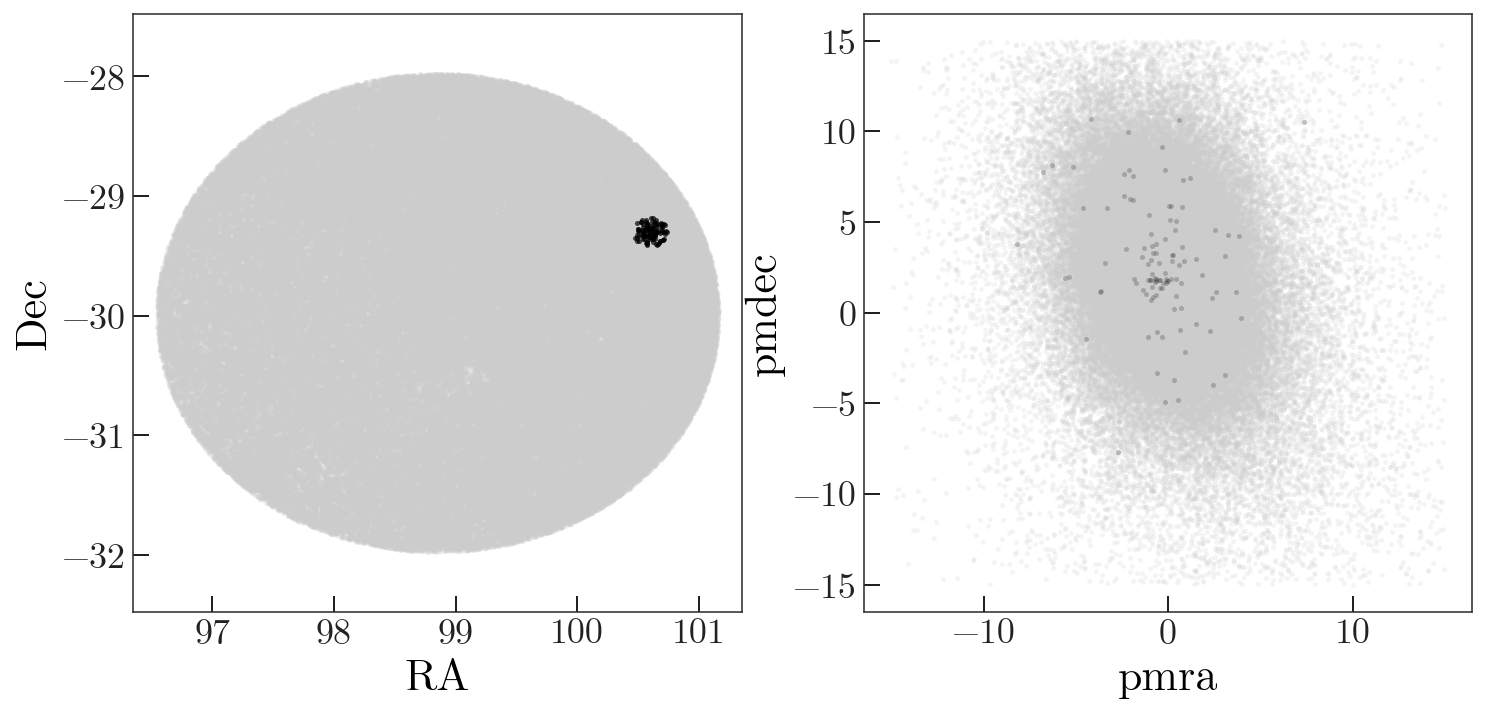

In [202]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))

axes[0].plot(group.ra, group.dec, marker='.', alpha=0.2, color='#cccccc', linestyle='none')
axes[0].plot(group.ra[derp_mask&cmd_mask], group.dec[derp_mask&cmd_mask], 
             marker='.', alpha=0.7, color='k', linestyle='none')
axes[0].set_xlabel('RA')
axes[0].set_ylabel('Dec')
axes[0].set_xlim(_x - 2.5, _x + 2.5)
axes[0].set_ylim(_y - 2.5, _y + 2.5)
# axes[0].set_xlim(100, _x + 2)
# axes[0].set_ylim(-30, -28.5)
axes[0].scatter(gals_c.ra.degree, gals_c.dec.degree)

axes[1].plot(group.pmra, group.pmdec, marker='.', alpha=0.2, color='#cccccc', linestyle='none')
axes[1].plot(group.pmra[derp_mask&cmd_mask], group.pmdec[derp_mask&cmd_mask], 
             marker='.', alpha=0.2, color='k', linestyle='none')
axes[1].set_xlabel('pmra')
axes[1].set_ylabel('pmdec')

---

### Magellanic Leading Stream star-formation

https://arxiv.org/pdf/1511.05853.pdf
http://iopscience.iop.org/article/10.1086/587042/pdf

In [31]:
pmra = np.mean(c[cls_to_idx2[1]].pm_ra_cosdec)
pmdec = np.mean(c[cls_to_idx2[1]].pm_dec)

In [32]:
g2 = GaiaData('../data/mag-leading-stream.fits')

In [98]:
pm_mask2 = np.sqrt((g2.pmra - pmra)**2 + (g2.pmdec - pmdec)**2) < 0.75*u.mas/u.yr

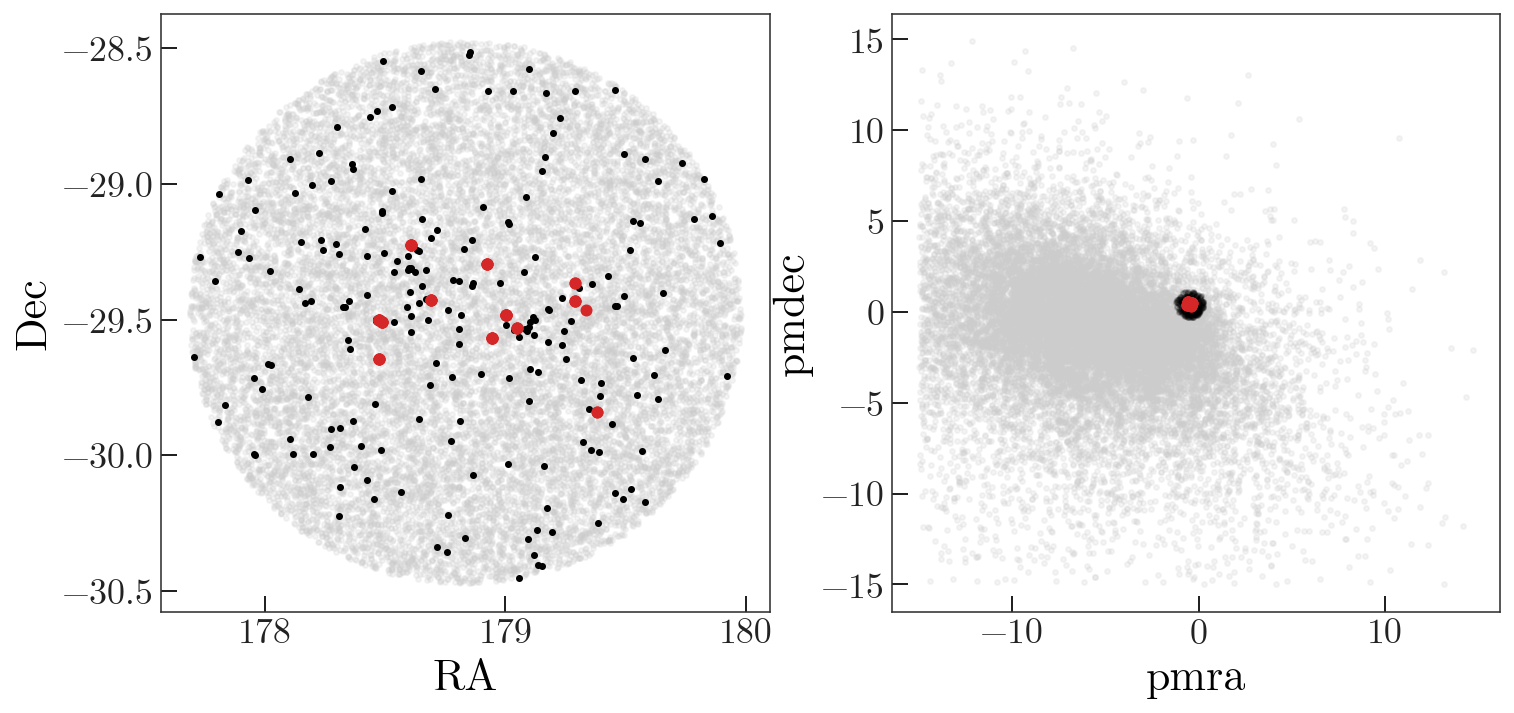

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))

axes[0].scatter(g2.ra, g2.dec, marker='.', alpha=0.2, color='#cccccc')
axes[0].scatter(g2.ra[pm_mask2], g2.dec[pm_mask2], marker='.', alpha=1., color='k')
axes[0].scatter(c[cls_to_idx2[1]].ra, c[cls_to_idx2[1]].dec, marker='o', color='tab:red')
axes[0].set_xlabel('RA')
axes[0].set_ylabel('Dec')

axes[1].scatter(g2.pmra, g2.pmdec, marker='.', alpha=0.2, color='#cccccc')
axes[1].scatter(g2.pmra[pm_mask2], g2.pmdec[pm_mask2], marker='.', alpha=0.2, color='k')
axes[1].scatter(c[cls_to_idx2[1]].pm_ra_cosdec, c[cls_to_idx2[1]].pm_dec, marker='o', color='tab:red')
axes[1].set_xlabel('pmra')
axes[1].set_ylabel('pmdec')

fig.savefig('sky_pm.png', dpi=250)

In [115]:
(np.mean(c[cls_to_idx2[1]].pm_ra_cosdec),
 np.mean(c[cls_to_idx2[1]].pm_dec))

(<Quantity -0.4777795 mas / yr>, <Quantity 0.44950373 mas / yr>)

In [53]:
(np.mean(c[cls_to_idx2[1]].galactic.l.degree),
 np.mean(c[cls_to_idx2[1]].galactic.b.degree))

(288.5526812437784, 31.826496040509596)

In [71]:
g3 = GaiaData('/Users/adrian/Downloads/1525908601756O-result.fits')

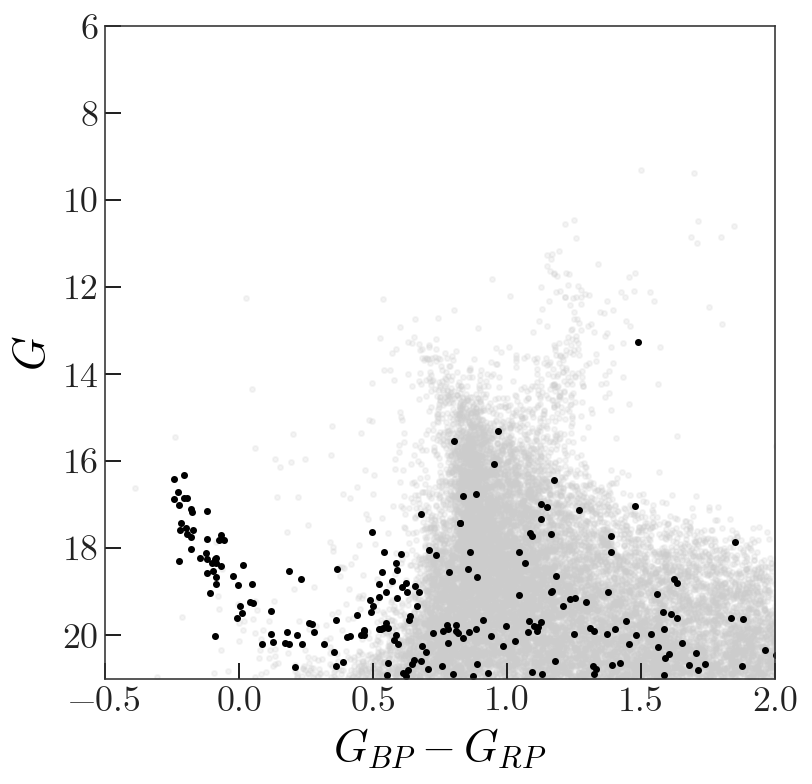

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(g2.bp_rp, g2.phot_g_mean_mag, marker='.', alpha=0.2, color='#cccccc')
ax.scatter(g2.bp_rp[pm_mask2], g2.phot_g_mean_mag[pm_mask2], marker='.', alpha=1., color='k')

# ax.scatter(g3.bp_rp, g3.phot_g_mean_mag, marker='.', alpha=1)

ax.set_xlim(-0.5, 2.)
ax.set_ylim(21, 6)
ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$G$')

fig.savefig('cmd.png', dpi=250)

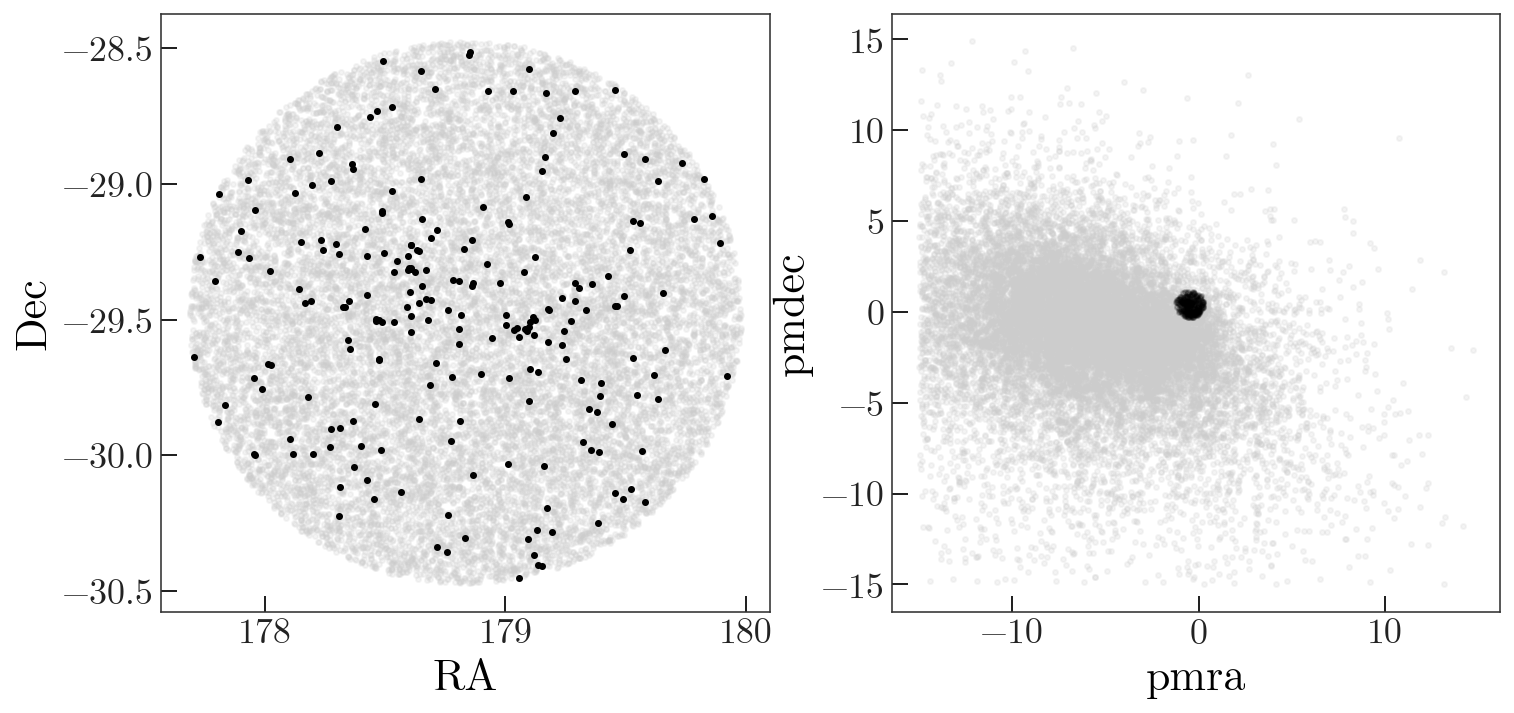

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))

axes[0].scatter(g2.ra, g2.dec, marker='.', alpha=0.2, color='#cccccc')
axes[0].scatter(g2.ra[pm_mask2], g2.dec[pm_mask2], marker='.', alpha=1., color='k')
# axes[0].scatter(g3.ra, g3.dec, marker='.', alpha=0.2, color='#cccccc')
# axes[0].scatter(g3.ra[pm_mask3], g3.dec[pm_mask3], marker='.', alpha=1., color='k')
axes[0].set_xlabel('RA')
axes[0].set_ylabel('Dec')

axes[1].scatter(g2.pmra, g2.pmdec, marker='.', alpha=0.2, color='#cccccc')
axes[1].scatter(g2.pmra[pm_mask2], g2.pmdec[pm_mask2], marker='.', alpha=0.2, color='k')
# axes[1].scatter(g3.pmra, g3.pmdec, marker='.', alpha=0.2, color='#cccccc')
# axes[1].scatter(g3.pmra[pm_mask3], g3.pmdec[pm_mask3], marker='.', alpha=0.8, color='k')
axes[1].scatter(c[cls_to_idx2[1]].pm_ra_cosdec, c[cls_to_idx2[1]].pm_dec, marker='o', color='tab:red')
axes[1].set_xlabel('pmra')
axes[1].set_ylabel('pmdec')

fig.savefig('sky_pm.png', dpi=250)

In [116]:
wtf = coord.SkyCoord(ra=g2.ra[pm_mask2],
                     dec=g2.dec[pm_mask2])

In [117]:
import gala.coordinates as gc

In [119]:
mag = wtf.transform_to(gc.MagellanicStream)

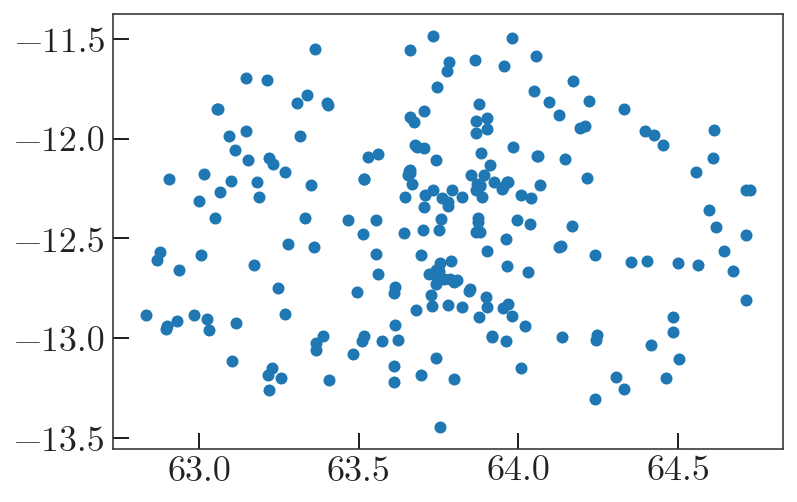

In [120]:
plt.scatter(mag.L.degree, mag.B.degree)